# Comparing even and odd-year voting behavior in Boulder, Colorado
By Brian C. Keegan, Ph.D.  
August 2022  
Copyright under a [MIT License](https://opensource.org/licenses/MIT)  

## Importing libraries

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np

pd.options.display.max_columns = 200
idx = pd.IndexSlice

# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, StrMethodFormatter
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
import seaborn as sb

# Statistics
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Geospatial libraries
import geopandas as gpd
from pyproj import CRS
import geoplot.crs as gcrs
import contextily, geoplot

## Loading data

### State Demography office

The "Single Year of Age" data is availablef or 1990 with estimates through 2050: https://demography.dola.colorado.gov/assets/html/sdodata.html

In [2]:
sya_df = pd.read_csv('sya-county.csv')

### Historical voting data

From the appendices at the bottom of the notebook.

In [3]:
cob_voter_long_gb_precinct_df = pd.read_csv('cob_precinct_turnout.csv')

cob_voter_long_gb_precinct_df.head()


,ELECTION,PRECINCT,AGE,VOTERS,VOTED,TURNOUT,CYCLE
0,2000,2181007800,18-24,12.0,8.0,0.666667,Even
1,2000,2181007800,25-34,40.0,35.0,0.875000,Even
2,2000,2181007800,35-44,92.0,89.0,0.967391,Even
3,2000,2181007800,45-54,78.0,76.0,0.974359,Even
4,2000,2181007800,55-64,33.0,33.0,1.000000,Even


### Precinct-level data

Load the precinct-level voter data, age, race, and property data from the appendices at the bottom of the notebook.

In [4]:
cob_precinct_data_gdf = gpd.read_file('cob_precinct_data.geojson',driver='GeoJSON')

cob_precinct_data_gdf.head(2)

,OBJECTID,DISTRICT,PRECINCT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,area,Even,Odd,Diff,id,Geographic Area Name,Total,Hispanic,White,Black,Native,Asian,Other,Multiracial,White_Pct,AGE,totalActualVal,geometry
0,16,2181307872,872,872,None,None,3.054629e+06,8731.439637,484221.577189,0.804753,0.405524,0.399229,7000000US08013013872,"Boulder 872, Boulder County, Colorado",1544,122,1282,14,0,58,7,61,0.830311,35.720596,824800.0,"POLYGON ((-105.26972 40.00455, -105.26954 40.0..."
1,17,2181307881,881,881,None,None,5.884699e+06,17196.013030,933204.194703,0.874860,0.562100,0.312760,7000000US08013013881,"Boulder 881, Boulder County, Colorado",948,76,778,12,7,22,4,49,0.820675,52.040837,884800.0,"POLYGON ((-105.27928 40.01583, -105.28323 40.0..."


The 88 precinct numbers unique to the City of Boulder.

In [5]:
cob_precinct_nums = cob_precinct_data_gdf['DISTRICT'].unique().tolist()

### Statement of votes 
Official statement of votes for the 2021 and 2020 elections from the Boulder County Clerk's Office: https://bouldercounty.gov/elections/by-year/

In [6]:
sov21_df = pd.read_excel(
    '2021-election-sov.xlsx',
    dtype={'Precinct Name':str}
)

sov21_df = sov21_df.rename(
    columns = {
        'Contest Title':'Contest Name'
    }
)

sov21_df['Fraction'] = sov21_df['Total Votes']/sov21_df['Total Ballots']
sov21_df['Turnout'] = sov21_df['Total Votes']/sov21_df['Active Voters']

cob_sov21_df = sov21_df[sov21_df['Precinct Name'].isin(cob_precinct_nums)]

cob_sov21_df.head(2)

,Precinct Name (Short),Precinct Name,Active Voters,Contest Name,Choice Name,Total Ballots,Total Votes,Total Undervotes,Total Overvotes,Fraction,Turnout
0,800,2181007800,441,City of Boulder Council Candidates,Michael Christy,263,127,303,1,0.482890,0.287982
1,800,2181007800,441,City of Boulder Council Candidates,Mark Wallach,263,126,303,1,0.479087,0.285714


In [7]:
sov20_df = pd.read_excel(
    '2020-election-sov.xlsx',
    dtype={'Precinct Name':str}
)

sov20_df = sov20_df.rename(
    columns = {
        'Active\nVoters':'Active Voters'
    }
)

sov20_df['Fraction'] = sov20_df['Total Votes']/sov20_df['Total Ballots']
sov20_df['Turnout'] = sov20_df['Total Votes']/sov20_df['Active Voters']

cob_sov20_df = sov20_df[sov20_df['Precinct Name'].isin(cob_precinct_nums)]

cob_sov20_df.head(2)

,Precinct Name (Short),Precinct Name,Active Voters,Contest Name,Choice Name,Party,Total Ballots,Total Votes,Total Undervotes,Total Overvotes,Fraction,Turnout
3168,800,2181007800,897,Presidential Electors,Joseph R. Biden / Kamala D. Harris,DEM,846,650,7,0,0.768322,0.724638
3169,800,2181007800,897,Presidential Electors,Donald J. Trump / Michael R. Pence,REP,846,171,7,0,0.202128,0.190635


## Analyses

### Turnout

In [37]:
# Groupby contest and precinct, aggregate by total votes and voters
cob_sov21_turnout_df = cob_sov21_df.groupby(['Contest Name','Precinct Name']).agg({'Total Votes':'sum','Active Voters':'max'})

# Add up votes and voters across precincts
cob_sov21_turnout_df = cob_sov21_turnout_df.groupby(level=0).sum()

# Calculate turnout
sov21_turnout = cob_sov21_turnout_df['Total Votes'] / cob_sov21_turnout_df['Active Voters']

# Print results
print("The largest turnout across contests in 2021 was: {0:.2%}".format(sov21_turnout[sov21_turnout < 1].max()))

The largest turnout across contests in 2021 was: 47.98%


In [38]:
# Groupby contest and precinct, aggregate by total votes and voters
cob_sov20_turnout_df = cob_sov20_df.groupby(['Contest Name','Precinct Name']).agg({'Total Votes':'sum','Active Voters':'max'})

# Add up votes and voters across precincts
cob_sov20_turnout_df = cob_sov20_turnout_df.groupby(level=0).sum()

# Calculate turnout
sov20_turnout = cob_sov20_turnout_df['Total Votes'] / cob_sov20_turnout_df['Active Voters']

# Print results
print("The largest turnout across contests in 2020 was: {0:.2%}".format(sov20_turnout[sov20_turnout < 1].max()))

The largest turnout across contests in 2020 was: 89.11%


In [39]:
# Avg turnout drop-off
_avg = cob_precinct_data_gdf['Diff'] > cob_precinct_data_gdf['Diff'].mean()

cob_precinct_data_gdf.loc[_avg,['PRECINCT','Diff']].sort_values('Diff').head()

,PRECINCT,Diff
78,814,0.345261
56,832,0.350511
72,806,0.351001
42,824,0.353470
22,855,0.355246


In [40]:
# Max turnout drop-off
_max = cob_precinct_data_gdf['Diff'] == cob_precinct_data_gdf['Diff'].max()
cob_precinct_data_gdf.loc[_max,['PRECINCT','Diff']]

,PRECINCT,Diff
41,834,0.621754


In [41]:
# Max turnout drop-off
_min = cob_precinct_data_gdf['Diff'] == cob_precinct_data_gdf['Diff'].min()
cob_precinct_data_gdf.loc[_min,['PRECINCT','Diff']]

,PRECINCT,Diff
65,851,0.184822


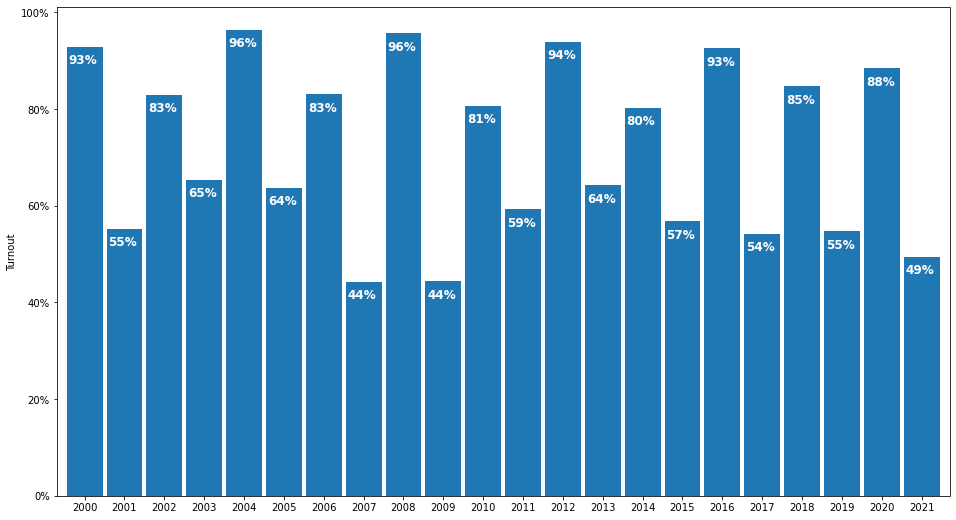

In [42]:
annual_turnout_df = cob_voter_long_gb_precinct_df.groupby('ELECTION').agg({'VOTERS':'sum','VOTED':'sum'})
annual_turnout_df['Turnout'] = annual_turnout_df['VOTED'] / annual_turnout_df['VOTERS']

f,ax = plt.subplots(figsize=(16,9))
annual_turnout_df['Turnout'].plot.bar(ax=ax,width=.9)

for p in ax.patches:
    ax.text(
        x = p.get_x() + .05, 
        y = p.get_height() - .035, 
        s = '{0:.0%}'.format(p.get_height()), 
        color = 'white',
        rotation = 'horizontal',
        weight = 'semibold',
        ha = 'left',
        size = 'large'
    )
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_xlabel(None)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
ax.set_ylabel('Turnout')

f.savefig('turnout_over_time.png')

Make a choropleth of average turnout in odd and even years.

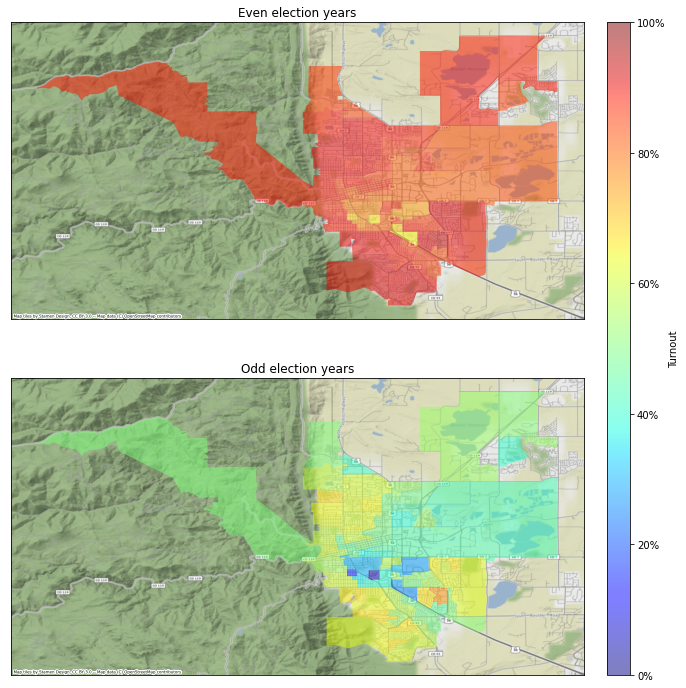

In [43]:
# gridspec = {'width_ratios':[1,1]}
f,axs = plt.subplots(2,1,figsize=(16,12))#,gridspec_kw=gridspec)

cob_precinct_data_gdf.plot(
    column = 'Even',
    ax = axs[0],
    vmin = 0,
    vmax = 1,
    cmap = 'jet',
    alpha = .5
)

cob_precinct_data_gdf.plot(
    column = 'Odd',
    ax = axs[1],
    vmin = 0,
    vmax = 1,
    cmap = 'jet',
    alpha = .5,
)

for ax in axs[:2]:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    contextily.add_basemap(
        ax,
        source = contextily.providers.Stamen.Terrain,
        crs = 'EPSG:4326',
        attribution_size = 4
    )

# f.suptitle('Average turnout, 2000—2021',fontsize=15)
axs[0].set_title('Even election years')
axs[1].set_title('Odd election years')

# https://stackoverflow.com/a/56900830/1574687
cax = f.add_axes(
    [axs[1].get_position().x1+.02,
     axs[1].get_position().y0,
     0.02,
     axs[0].get_position().y1-axs[1].get_position().y0
    ]
)
f.colorbar(
    cm.ScalarMappable(norm=Normalize(vmin=0,vmax=1),cmap=cm.jet),
    orientation='vertical',
    alpha=.5,
    format=PercentFormatter(1,0),
    cax=cax,
    label='Turnout'
)

f.savefig('precinct_avg_turnout_even_odd.png',facecolor='w',bbox_inches='tight')

Make a choropleth of the difference in turnouts by precinct.

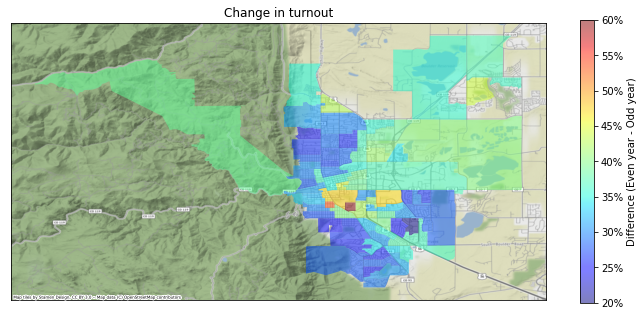

In [51]:
ax = cob_precinct_data_gdf.plot(
    column = 'Diff',
    cmap = 'jet',
    figsize = (12,8),
    alpha = .5,
    legend = True,
    vmax=.6,
    vmin=.2,
    legend_kwds = {'label':'Difference (Even year - Odd year)','format':PercentFormatter(1,0),'shrink':.65,'alpha':.5}
)

contextily.add_basemap(
    ax,
    source = contextily.providers.Stamen.Terrain,
    crs = 'EPSG:4326',
    attribution_size = 4
)

ax.set_title('Change in turnout')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('precinct_turnout_diff.png',facecolor='w',bbox_inches='tight')

### Housing values

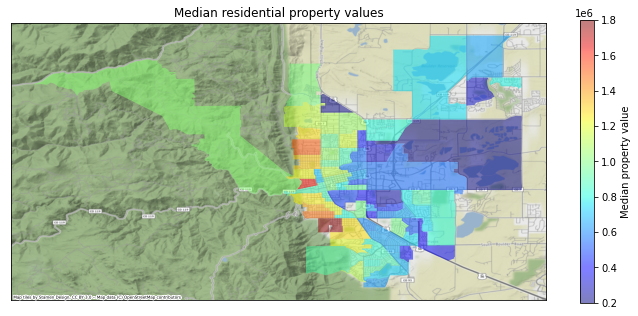

In [45]:
ax = cob_precinct_data_gdf.plot(
    column = 'totalActualVal',
    cmap = 'jet',
    figsize = (12,8),
    alpha = .5,
    legend = True,
    vmin=200000,
    vmax=1800000,
    legend_kwds = {'label':'Median property value','shrink':.65,'alpha':.5}
)

contextily.add_basemap(
    ax,
    source = contextily.providers.Stamen.Terrain,
    crs = 'EPSG:4326',
    attribution_size = 4
)

ax.set_title('Median residential property values')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('precinct_res_value.png',facecolor='w',bbox_inches='tight')

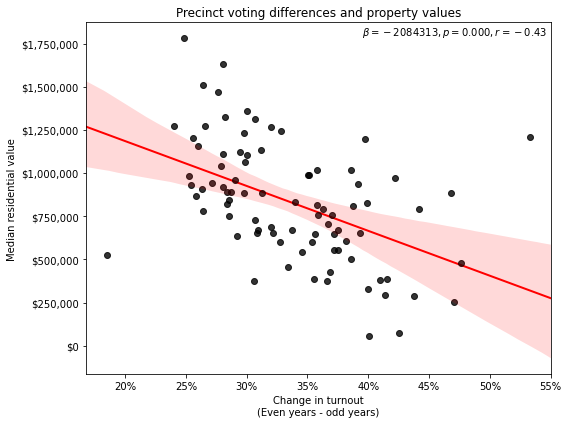

In [46]:
f,ax = plt.subplots(1,1,figsize=(8,6))

g = sb.regplot(
    data = cob_precinct_data_gdf,
    x = 'Diff',
    y = 'totalActualVal',
    ax = ax,
    scatter_kws = {'color':'k'},
    line_kws = {'color':'red','lw':2,'zorder':-1},
    truncate = False
)

# ax.set_xlim((.2,.65))
# ax.set_ylim((.45,1))

ax.set_title('Precinct voting differences and property values')
ax.set_xlabel('Change in turnout\n(Even years - odd years)')
ax.set_ylabel('Median residential value')

ax.xaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
ax.yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))

# ax.axvline(cob_precinct_race_turnout_gdf['Diff'].mean(),c='k',lw=1,ls='--')
# ax.axhline(cob_precinct_race_turnout_gdf['White Pct'].mean(),c='k',lw=1,ls='--')

regress = stats.linregress(cob_precinct_data_gdf['Diff'].fillna(cob_precinct_data_gdf['Diff'].mean()),cob_precinct_data_gdf['totalActualVal'].fillna(cob_precinct_data_gdf['totalActualVal'].mean()))
ax.text(.395,1.8e6,s=r"$\beta={0.slope:.0f}, p={0.pvalue:.3f}, r={0.rvalue:.2f}$".format(regress))

f.tight_layout()
f.savefig('voting_diff_res_value.png',dpi=300,facecolor='w',bbox_inches='tight')

### Age

Using the Single-Year Age estimates, plot annual age demographics.

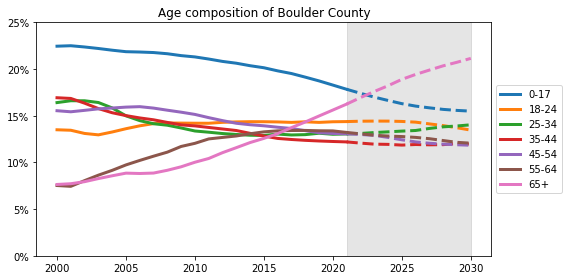

In [47]:
_c0 = sya_df['age'] >= 18
_c1 = sya_df['county'] == 'Boulder'
_c2 = sya_df['year'].isin(range(2000,2031))

sya_boulder = sya_df.loc[_c1 & _c2,['year','age','totalpopulation']]

sya_boulder['age_cut'] = pd.cut(
    x = sya_boulder['age'],
    bins = [0,18,25,35,45,55,65,110],
    right = False,
    labels = ['0-17','18-24','25-34','35-44','45-54','55-64','65+']
)

age_colormap = {
    '0-17':'tab:blue',
    '18-24':'tab:orange',
    '25-34':'tab:green',
    '35-44':'tab:red',
    '45-54':'tab:purple',
    '55-64':'tab:brown',
    '65+':'tab:pink'
}

sya_cut_df = sya_boulder.groupby(['year','age_cut']).agg({'totalpopulation':'sum'})['totalpopulation'].unstack(1)

f,ax = plt.subplots(figsize=(8,4))
_df = sya_cut_df.div(sya_cut_df.sum(1),axis=0)
_df.loc[:2021].plot(lw=3,ax=ax,color=age_colormap,legend=False)
_df.loc[2021:].plot(lw=3,ls='--',ax=ax,color=age_colormap,legend=False)

custom_legend_lines = [Line2D([0],[0], color = _c, lw = 3) for _c in age_colormap.values()]
ax.legend(custom_legend_lines,age_colormap.keys(),loc='center left',bbox_to_anchor=(1,.5))

ax.set_ylim((0,.25))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
ax.set_xlabel(None)
ax.set_title('Age composition of Boulder County')
ax.axvspan(2021,2030,color='k',alpha=.1)

f.tight_layout()
f.savefig('demographics_age.png',facecolor='w',bbox_inches='tight')

Make a barplot of voting activity by age demographics.

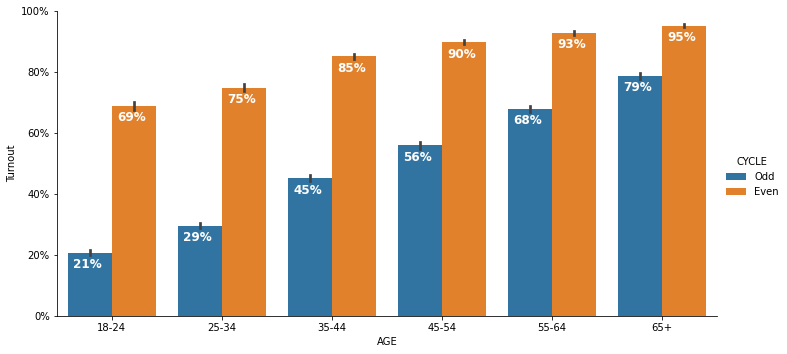

In [48]:
g = sb.catplot(
    data = cob_voter_long_gb_precinct_df,
    x = 'AGE',
    y = 'TURNOUT',
    hue = 'CYCLE',
    hue_order = ['Odd','Even'],
    kind = 'bar',
    palette = 'tab10',
    aspect = 2,
    dodge = .5
)

ax = g.facet_axis(0,0)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
ax.set_ylim((0,1))
ax.set_ylabel('Turnout')

for p in ax.patches:
    ax.text(
        x = p.get_x() + .05, 
        y = p.get_height() - .05, 
        s = '{0:.0%}'.format(p.get_height()), 
        color = 'white',
        rotation = 'horizontal',
        weight = 'semibold',
        ha = 'left',
        size = 'large'
    )
    
plt.savefig('turnout_by_age.png',facecolor='w')

Make a choropleth of voting by age.

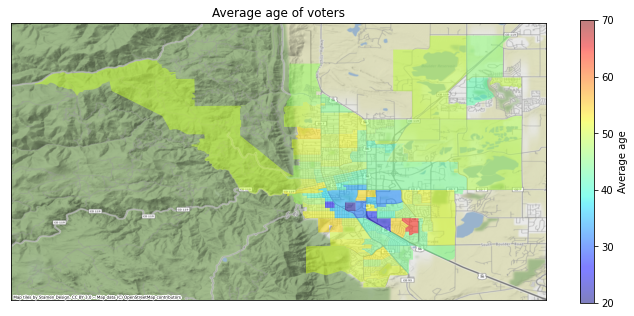

In [49]:
ax = cob_precinct_data_gdf.plot(
    column = 'AGE',
    cmap = 'jet',
    figsize = (12,8),
    alpha = .5,
    legend = True,
    vmax=70,
    vmin=20,
    legend_kwds = {'label':'Average age','shrink':.65,'alpha':.5}
)

contextily.add_basemap(
    ax,
    source = contextily.providers.Stamen.Terrain,
    crs = 'EPSG:4326',
    attribution_size = 4
)

ax.set_title('Average age of voters')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('precinct_avg_age.png',facecolor='w',bbox_inches='tight')

Make a scatterplot and estimate a linear model of the relationship between turnout drop-off and age.

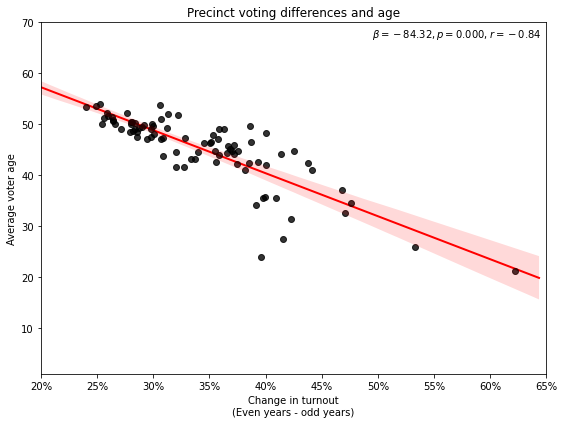

In [50]:
f,ax = plt.subplots(1,1,figsize=(8,6))

g = sb.regplot(
    data = cob_precinct_data_gdf,
    x = 'Diff',
    y = 'AGE',
    ax = ax,
    scatter_kws = {'color':'k'},
    line_kws = {'color':'red','lw':2,'zorder':-1},
    truncate = False
)

ax.set_xlim((.2,.65))
ax.set_ylim((1,70))

ax.set_title('Precinct voting differences and age')
ax.set_xlabel('Change in turnout\n(Even years - odd years)')
ax.set_ylabel('Average voter age')

ax.xaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

regress = stats.linregress(cob_precinct_data_gdf['Diff'],cob_precinct_data_gdf['AGE'])
ax.text(.495,67,s=r"$\beta={0.slope:.2f}, p={0.pvalue:.3f}, r={0.rvalue:.2f}$".format(regress))

f.tight_layout()
f.savefig('voting_diff_age.png',dpi=300,facecolor='w',bbox_inches='tight')

### Regression model

In [29]:
m = smf.ols("Diff ~ AGE + np.log(totalActualVal)",data=cob_precinct_data_gdf).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     145.3
Date:                Mon, 01 Aug 2022   Prob (F-statistic):           7.63e-28
Time:                        14:11:15   Log-Likelihood:                 180.49
No. Observations:                  86   AIC:                            -355.0
Df Residuals:                      83   BIC:                            -347.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

## Appendices
### Appendix 1: Cleaning and joining voter details and history

This section includes data cleanup steps using datasets that are large or not permitted for public hosting.

#### Election dates

In [2]:
election_dates = pd.to_datetime(
    ['2000-11-07','2001-11-06','2002-11-05','2003-11-04','2004-11-02',
     '2005-11-01','2006-11-07','2007-11-06','2008-11-04','2009-11-03',
     '2010-11-02','2011-11-01','2012-11-06','2013-11-05','2014-11-04',
     '2015-11-03','2016-11-08','2017-11-07','2018-11-06','2019-11-05',
     '2020-11-03','2021-11-02'
    ]
)

election_dates_map = {date.year:date for date in election_dates}
election_dates_map

{2000: Timestamp('2000-11-07 00:00:00'),
 2001: Timestamp('2001-11-06 00:00:00'),
 2002: Timestamp('2002-11-05 00:00:00'),
 2003: Timestamp('2003-11-04 00:00:00'),
 2004: Timestamp('2004-11-02 00:00:00'),
 2005: Timestamp('2005-11-01 00:00:00'),
 2006: Timestamp('2006-11-07 00:00:00'),
 2007: Timestamp('2007-11-06 00:00:00'),
 2008: Timestamp('2008-11-04 00:00:00'),
 2009: Timestamp('2009-11-03 00:00:00'),
 2010: Timestamp('2010-11-02 00:00:00'),
 2011: Timestamp('2011-11-01 00:00:00'),
 2012: Timestamp('2012-11-06 00:00:00'),
 2013: Timestamp('2013-11-05 00:00:00'),
 2014: Timestamp('2014-11-04 00:00:00'),
 2015: Timestamp('2015-11-03 00:00:00'),
 2016: Timestamp('2016-11-08 00:00:00'),
 2017: Timestamp('2017-11-07 00:00:00'),
 2018: Timestamp('2018-11-06 00:00:00'),
 2019: Timestamp('2019-11-05 00:00:00'),
 2020: Timestamp('2020-11-03 00:00:00'),
 2021: Timestamp('2021-11-02 00:00:00')}

#### Voter details

The Registered Voter Data file can be requested from the Boulder County Clerk's Office: https://bouldercounty.gov/elections/maps-and-data/data-access/

In [3]:
mvh_details_df1 = pd.read_csv(
    '../Data/Elections/Master_Voting_History_List_Voter_Details_Part1_11_28_2021.txt.txt',
    dtype = {
        'VOTER_ID':str,
        'HOUSE_NUM':str,
        'RESIDENTIAL_ZIP_CODE':str,
        'MAILING_ZIP_CODE':str,
        'BIRTH_YEAR':float,
        'PRECINCT_CODE':str
    },
    parse_dates = ['REGISTRATION_DATE','EFFECTIVE_DATE','LAST_UPDATED_DATE']
)

mvh_details_df2 = pd.read_csv(
    '../Data/Elections/Master_Voting History_List_Voter_Details_Part2_11_28_2021.txt.txt',
    dtype = {
        'VOTER_ID':str,
        'HOUSE_NUM':str,
        'RESIDENTIAL_ZIP_CODE':str,
        'MAILING_ZIP_CODE':str,
        'BIRTH_YEAR':float,
        'PRECINCT_CODE':str
    },
    parse_dates = ['REGISTRATION_DATE','EFFECTIVE_DATE','LAST_UPDATED_DATE']
)

voter_details_df = pd.concat([mvh_details_df1,mvh_details_df2])
voter_details_df.reset_index(drop=True,inplace=True)
print("{0:,}".format(len(voter_details_df)))
voter_details_df.head(2)

C:\Users\Brian\AppData\Local\Temp\ipykernel_39824\986634869.py:1: DtypeWarning: Columns (59) have mixed types. Specify dtype option on import or set low_memory=False.
  mvh_details_df1 = pd.read_csv(


247,569


,VOTER_ID,COUNTY,FIRST_NAME,MIDDLE_NAME,LAST_NAME,NAME_SUFFIX,REGISTRATION_DATE,EFFECTIVE_DATE,LAST_UPDATED_DATE,OLD_VOTER_ID,PHONE_NUM,HOUSE_NUM,HOUSE_SUFFIX,PRE_DIR,STREET_NAME,STREET_TYPE,POST_DIR,UNIT_TYPE,UNIT_NUM,RESIDENTIAL_ADDRESS,RESIDENTIAL_CITY,RESIDENTIAL_STATE,RESIDENTIAL_ZIP_CODE,RESIDENTIAL_ZIP_PLUS,MAILING_ADDRESS_1,MAILING_ADDRESS_2,MAILING_ADDRESS_3,MAILING_CITY,MAILING_STATE,MAILING_ZIP_CODE,MAILING_ZIP_PLUS,MAILING_COUNTRY,VOTER_STATUS,STATUS_REASON,PARTY,GENDER,BIRTH_YEAR,PRECINCT_CODE,PRECINCT_NAME,Federal,Congressional,Statewide,State Board of Education - At Large,State Board of Education,University of Colorado Regents - At Large,University of Colorado Regents,State Senate,State House,Judicial,Regional Transportation,County Commissioner,Countywide,Municipality,City Ward/District,School,Conservation,Downtown Development Authority,Drainage and Flood Control,Fire Protection,Fire Protection 2,General Improvement,Library,Metropolitan,Miscellaneous General Improvement,Miscellaneous Other,Park and Recreation,Proposed,Proposed 2,Public Improvement,Public Improvement 2,Sanitation,Scientific Cultural Facilities,Special Improvement,Urban Renewal/Reinvestment Authority,Water and Sanitation,Water Conservancy,Water Conservancy 3,Water,Water 2
0,602043987,Boulder,MATTHEW,NaN,LUO,NaN,2019-06-24,2019-06-24,2020-11-25,NaN,NaN,727,NaN,NaN,NIGHTHAWK,CIR,NaN,NaN,NaN,727 NIGHTHAWK CIR,LOUISVILLE,CO,80027,NaN,727 NIGHTHAWK CIR,NaN,NaN,LOUISVILLE,CO,80027,NaN,NaN,Active,NaN,UAF,Unknown,2002.0,2171207208,2.171207e+09,FED,2.0,CO,BE,2.0,UC,2.0,17.0,12.0,20.0,RTD O,NaN,7.0,LOUISVILLE,LVCW2,BVSD,NaN,NaN,64147.0,7027.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SCFD,NaN,NaN,NaN,64105.0,NaN,NaN,NaN
1,600895121,Boulder,ROBERT,RILEY,NEREM,NaN,2014-05-16,2020-11-03,2020-11-25,NaN,NaN,4575,NaN,NaN,TALLY HO,TRL,NaN,NaN,NaN,4575 TALLY HO TRL,BOULDER,CO,80301,NaN,4575 TALLY HO TRL,NaN,NaN,BOULDER,CO,80301,NaN,NaN,Active,Failed to Vote,DEM,Male,1996.0,2181007500,2.181008e+09,FED,2.0,CO,BE,2.0,UC,2.0,18.0,10.0,20.0,RTD O,NaN,7.0,NaN,NaN,BVSD,64025.0,NaN,64147.0,7057.0,NaN,NaN,NaN,NaN,7061.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SCFD,NaN,NaN,NaN,64105.0,NaN,NaN,NaN


In [4]:
cob_precinct_nums = voter_details_df.loc[voter_details_df['Municipality'] == 'BOULDER','PRECINCT_CODE'].unique()
print("There are {0} precincts.".format(len(cob_precinct_nums)))

There are 88 precincts.


#### Voting history

The Master Voter History file can be requested from the Boulder County Clerk's Office: https://bouldercounty.gov/elections/maps-and-data/data-access/

In [5]:
mvh_l_df1 = pd.read_csv(
    '../Data/Elections/Master_Voting_History_List_Part1_11_28_2021.txt.txt',
    parse_dates = ['ELECTION_DATE'],
    dtype = {
        'VOTER_ID':str
    }
)

mvh_l_df2 = pd.read_csv(
    '../Data/Elections/Master_Voting_History_List_Part2_11_28_2021.txt.txt',
    parse_dates = ['ELECTION_DATE'],
    dtype = {
        'VOTER_ID':str
    }
)

mvh_l_df3 = pd.read_csv(
    '../Data/Elections/Master_Voting_History_List_Part3_11_28_2021.txt.txt',
    parse_dates = ['ELECTION_DATE'],
    dtype = {
        'VOTER_ID':str
    }
)

mvh_l_df4 = pd.read_csv(
    '../Data/Elections/Master_Voting_History_List_Part4_11_28_2021.txt.txt',
    parse_dates = ['ELECTION_DATE'],
    dtype = {
        'VOTER_ID':str
    }
)

voting_history_df = pd.concat([mvh_l_df1,mvh_l_df2,mvh_l_df3,mvh_l_df4])
voting_history_df.dropna(subset=['ELECTION_DESCRIPTION'],inplace=True)
voting_history_df.reset_index(drop=True,inplace=True)

voting_history_df.replace(
    {'ELECTION_DESCRIPTION':{
        'General Election 2008':'2008 General Election',
        '2004 GENERAL ELECTION':'2004 General Election',
        '2006 GENERAL ELECTION':'2006 General Election',
        '2002 GENERAL ELECTION':'2002 General Election',
        '20001107':'2000 General Election',
    }
    },inplace=True)

print("{0:,}".format(len(voting_history_df)))

voting_history_df.head()

3,102,687


,VOTER_ID,ELECTION_TYPE,ELECTION_DATE,ELECTION_DESCRIPTION,VOTING_METHOD,PARTY,COUNTY_NAME
0,73343,General,2020-11-03,2020 Boulder County General Election,Mail Ballot,REP,Boulder
1,73343,General,2016-11-08,2016 Boulder County General Election,Mail Ballot,REP,Boulder
2,73343,General,2014-11-04,2014 Boulder County General Election,Absentee Mail,NO DATA,Boulder
3,73343,General,2012-11-06,2012 Boulder County General Election,Absentee Mail,NO DATA,Boulder
4,73343,General,2010-11-02,2010 Boulder County General Election,Absentee Mail,NO DATA,Boulder


#### Joining voting details and history
Focus on general and coordinated elections in Boulder County since 2000.

In [6]:
c0 = voting_history_df['ELECTION_TYPE'].isin(['General','Coordinated'])
c1 = voting_history_df['ELECTION_DATE'].isin(election_dates)
c2 = voting_history_df['COUNTY_NAME'] == 'Boulder'
recent_voting_history = voting_history_df[c0 & c1 & c2]
recent_voting_history.head()

,VOTER_ID,ELECTION_TYPE,ELECTION_DATE,ELECTION_DESCRIPTION,VOTING_METHOD,PARTY,COUNTY_NAME
0,73343,General,2020-11-03,2020 Boulder County General Election,Mail Ballot,REP,Boulder
1,73343,General,2016-11-08,2016 Boulder County General Election,Mail Ballot,REP,Boulder
2,73343,General,2014-11-04,2014 Boulder County General Election,Absentee Mail,NO DATA,Boulder
3,73343,General,2012-11-06,2012 Boulder County General Election,Absentee Mail,NO DATA,Boulder
4,73343,General,2010-11-02,2010 Boulder County General Election,Absentee Mail,NO DATA,Boulder


Calculate whether a VOTER_ID cast a ballot in each election.

In [7]:
recent_voting_pivot = pd.pivot_table(
    data = recent_voting_history,
    index = 'VOTER_ID',
    columns = 'ELECTION_DESCRIPTION',
    values = 'VOTING_METHOD',
    aggfunc = lambda x: len(list(x))
).fillna(0)

recent_voting_pivot.columns = recent_voting_pivot.columns.str.slice(0,4).astype(int)

recent_voting_pivot.head()

ELECTION_DESCRIPTION,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
VOTER_ID,,,,,,,,,,,,,,,,,,,,,,
1001523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
100189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1002603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1005696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
100606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Voters who did not cast a ballot in an election may not have been registered. Look up each voter's registration date and convert dates before they were registered to NaNs instead of 0s. This step will take several minutes.

Or just load the pre-computed file.

In [9]:
recent_voting_pivot = pd.read_csv('voterid_voting_history.csv')
recent_voting_pivot['VOTER_ID'] = recent_voting_pivot['VOTER_ID'].astype(str)
recent_voting_pivot.set_index('VOTER_ID',inplace=True)
recent_voting_pivot.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
VOTER_ID,,,,,,,,,,,,,,,,,,,,,,
1001523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
100189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1002603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1005696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
100606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Reshape `recent_voting_pivot` to long.

In [10]:
recent_voting_pivot_stacked = recent_voting_pivot.stack().reset_index()
recent_voting_pivot_stacked.columns = ['VOTER_ID','ELECTION_YEAR','VOTED'] 
recent_voting_pivot_stacked['ELECTION_YEAR'] = recent_voting_pivot_stacked['ELECTION_YEAR'].astype(int)

Join voting history with voter details.


In [11]:
voter_details_long_df = pd.merge(
    left = voter_details_df[['VOTER_ID','GENDER','BIRTH_YEAR','PRECINCT_CODE','REGISTRATION_DATE']],
    right = recent_voting_pivot_stacked,
    left_on = 'VOTER_ID',
    right_on = 'VOTER_ID',
    how = 'right'
)

voter_details_long_df['AGE'] = voter_details_long_df['ELECTION_YEAR'] - voter_details_long_df['BIRTH_YEAR']
voter_details_long_df['AGE_CUT'] = pd.cut(
    x = voter_details_long_df['AGE'],
    bins = [18,25,35,45,55,65,110],
    right = False,
    labels = ['18-24','25-34','35-44','45-54','55-64','65+']
)

voter_details_long_df['CYCLE'] = voter_details_long_df['ELECTION_YEAR'] % 2
voter_details_long_df.replace({'CYCLE':{1:'Odd',0:'Even'}},inplace=True)

voter_details_long_df.head()

,VOTER_ID,GENDER,BIRTH_YEAR,PRECINCT_CODE,REGISTRATION_DATE,ELECTION_YEAR,VOTED,AGE,AGE_CUT,CYCLE
0,1001523,Female,1974.0,4171207603,2009-11-13,2009,0.0,35.0,35-44,Odd
1,1001523,Female,1974.0,4171207603,2009-11-13,2010,0.0,36.0,35-44,Even
2,1001523,Female,1974.0,4171207603,2009-11-13,2011,0.0,37.0,35-44,Odd
3,1001523,Female,1974.0,4171207603,2009-11-13,2012,0.0,38.0,35-44,Even
4,1001523,Female,1974.0,4171207603,2009-11-13,2013,0.0,39.0,35-44,Odd


Group joined voting history and details by precinct.

In [12]:
voter_long_gb_precinct_df = voter_details_long_df.groupby(['ELECTION_YEAR','PRECINCT_CODE','AGE_CUT']).agg({'VOTED':[lambda x:x.notnull().sum(),'sum']})
voter_long_gb_precinct_df.columns = voter_long_gb_precinct_df.columns.droplevel(0)
voter_long_gb_precinct_df.reset_index(inplace=True)
voter_long_gb_precinct_df.columns = ['ELECTION','PRECINCT','AGE','VOTERS','VOTED']
voter_long_gb_precinct_df['TURNOUT'] = voter_long_gb_precinct_df['VOTED'] / voter_long_gb_precinct_df['VOTERS']
voter_long_gb_precinct_df['CYCLE'] = voter_long_gb_precinct_df['ELECTION'] % 2
voter_long_gb_precinct_df.replace({'CYCLE':{1:'Odd',0:'Even'}},inplace=True)

cob_voter_long_gb_precinct_df = voter_long_gb_precinct_df[voter_long_gb_precinct_df['PRECINCT'].isin(cob_precinct_nums)]

cob_voter_long_gb_precinct_df.to_csv('cob_precinct_turnout.csv',index=False)

cob_voter_long_gb_precinct_df.head()


,ELECTION,PRECINCT,AGE,VOTERS,VOTED,TURNOUT,CYCLE
348,2000,2181007800,18-24,12.0,8.0,0.666667,Even
349,2000,2181007800,25-34,40.0,35.0,0.875000,Even
350,2000,2181007800,35-44,92.0,89.0,0.967391,Even
351,2000,2181007800,45-54,78.0,76.0,0.974359,Even
352,2000,2181007800,55-64,33.0,33.0,1.000000,Even


In [13]:
precinct_turnout_df = voter_details_long_df.groupby(['ELECTION_YEAR','PRECINCT_CODE']).agg({'VOTED':[lambda x:x.notnull().sum(),'sum']})
precinct_turnout_df.columns = precinct_turnout_df.columns.droplevel(0)
precinct_turnout_df.reset_index(inplace=True)
precinct_turnout_df.columns = ['ELECTION','PRECINCT','VOTERS','VOTED']
precinct_turnout_df['TURNOUT'] = precinct_turnout_df['VOTED'] / precinct_turnout_df['VOTERS']
precinct_turnout_df['CYCLE'] = precinct_turnout_df['ELECTION'] % 2
precinct_turnout_df.replace({'CYCLE':{1:'Odd',0:'Even'}},inplace=True)

precinct_turnout_df.head(2)

,ELECTION,PRECINCT,VOTERS,VOTED,TURNOUT,CYCLE
0,2000,2161307900,193,179.0,0.927461,Even
1,2000,2161307901,176,158.0,0.897727,Even


In [14]:
cycle_precinct_turnout_df = precinct_turnout_df.groupby(['PRECINCT','CYCLE']).agg({'TURNOUT':'mean'})['TURNOUT'].unstack(1)
cycle_precinct_turnout_df['Diff'] = cycle_precinct_turnout_df['Even'] - cycle_precinct_turnout_df['Odd']

cycle_precinct_turnout_df.head(2)

CYCLE,Even,Odd,Diff
PRECINCT,,,
2161307900,0.894357,0.523062,0.371295
2161307901,0.860195,0.431657,0.428538


### Appendix 2: Precinct shapefile

From Boulder County Geospatial Open Data: https://opendata-bouldercounty.hub.arcgis.com/datasets/precincts/explore

In [15]:
precincts_gdf = gpd.read_file('../Data/Precincts/Precincts.shp',dtype={'PRECINCT':str})

precincts_gdf['area'] = precincts_gdf['geometry'].to_crs(3857).apply(lambda x:x.area)

precincts_gdf.head()

,OBJECTID,DISTRICT,PRECINCT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry,area
0,1,2181107506,2181107506,506,None,None,2.126887e+07,20223.228724,"POLYGON ((-105.15055 40.08733, -105.15056 40.0...",3.380607e+06
1,2,2181107702,2181107702,702,None,None,1.186144e+08,61359.675227,"POLYGON ((-105.14988 40.13407, -105.14963 40.1...",1.886895e+07
2,3,2181107505,2181107505,505,None,None,2.398745e+07,22560.123010,"POLYGON ((-105.16275 40.10161, -105.16275 40.1...",3.812751e+06
3,4,2181107701,2181107701,701,None,None,1.728000e+08,73356.477307,"POLYGON ((-105.18323 40.12389, -105.18323 40.1...",2.747601e+07
4,5,2181107705,2181107705,705,None,None,4.708790e+08,132293.031420,"POLYGON ((-105.15906 40.26122, -105.15905 40.2...",7.510660e+07


Subset to City of Boulder precincts.

In [16]:
cob_precincts_gdf = precincts_gdf.copy()[precincts_gdf['PRECINCT'].isin(cob_precinct_nums)]

### Appendix 3: Calculating property values

#### Load data from Assessor's office

In [18]:
accounts_df = pd.read_csv(
    '../Data/Property/Account_Parcels.csv',
    dtype = {'strap':str,'Parcelno':str}
)

strap_parcel_map = accounts_df.set_index('strap')['Parcelno'].to_dict()

accounts_df.head()

,strap,Parcelno
0,M2000001,146318113001
1,M2000002,146318113001
2,M2000003,146321300001
3,M2000004,146318113001
4,M2000007,146318113001


In [19]:
owners_df = pd.read_csv(
    '../Data/Property/Owner_Address.csv',
    dtype = {'folio':str}
)

owners_df['parcel'] = owners_df['strap'].map(strap_parcel_map)

residential_account_types = ['RESIDENTIAL','RESIDENTIAL CONDO','MANUFACTURED HOME','APARTMENT','AFFORDABLE RES']
residential_straps = owners_df.loc[owners_df['account_type'].isin(residential_account_types),'strap']

In [20]:
values_df = pd.read_csv(
    '../Data/Property/Values.csv'
)

values_df['parcel'] = values_df['strap'].map(strap_parcel_map)

values_df.head(2)

,strap,tax_yr,bldAcutalVal,LandAcutalVal,xfActualVal,totalActualVal,landAssessedVal,bldAssessedVal,xfAssessedVal,totalAssessedVal,status_cd,parcel
0,M2000001,2021,82400,0,NaN,82400,NaN,5892.0,NaN,5892,A,146318113001
1,M2000002,2021,49900,0,NaN,49900,NaN,3568.0,NaN,3568,A,146318113001


In [21]:
parcel_gdf = gpd.read_file(
    filename = '../Data/Parcels/Parcels.shp',
    dtype = {'OBJECTID':str,'PARCEL_NO':str}
)

parcel_gdf.head()

,OBJECTID,PARCEL_NO,PARCEL_NUM,SHAPEarea,SHAPElen,geometry
0,212255344,119711100008,None,58699.208205,975.378741,"POLYGON ((-105.53053 40.24237, -105.53052 40.2..."
1,212255345,119711100010,None,56571.092973,960.464141,"POLYGON ((-105.53053 40.24237, -105.52956 40.2..."
2,212255346,119701000022,None,330426.377815,2642.695555,"POLYGON ((-105.51099 40.24850, -105.51078 40.2..."
3,212255347,119702000019,None,827650.562208,4361.190661,"POLYGON ((-105.53258 40.26060, -105.53256 40.2..."
4,212255348,119702000021,None,63516.709173,1287.358317,"POLYGON ((-105.53544 40.25964, -105.53544 40.2..."


#### Spatial join parcels into precincts

Assign property parcels to voting precincts.

In [22]:
parcel_precinct_gdf = gpd.sjoin(
    left_df = parcel_gdf[['PARCEL_NO','geometry']],
    right_df = cob_precincts_gdf[['PRECINCT','ABBREVIATI','geometry']],
    predicate = 'within'
)

print(len(parcel_gdf),len(cob_precincts_gdf),len(parcel_precinct_gdf))

parcel_precinct_gdf.head(2)

128898 88 36562


,PARCEL_NO,geometry,index_right,PRECINCT,ABBREVIATI
27681,146124401001,"POLYGON ((-105.29097 40.03083, -105.29097 40.0...",45,2181307886,886
27682,146124401010,"POLYGON ((-105.29096 40.02934, -105.29141 40.0...",45,2181307886,886


#### Merge property values into parcel-precincts

In [23]:
values_precinct_gdf = pd.merge(
    left = parcel_precinct_gdf,
    right = values_df,
    how = 'inner',
    left_on = 'PARCEL_NO',
    right_on = 'parcel'
)

res_values_gdf = values_precinct_gdf[values_precinct_gdf['strap'].isin(residential_straps)]

res_values_gdf.head()

,PARCEL_NO,geometry,index_right,PRECINCT,ABBREVIATI,strap,tax_yr,bldAcutalVal,LandAcutalVal,xfActualVal,totalActualVal,landAssessedVal,bldAssessedVal,xfAssessedVal,totalAssessedVal,status_cd,parcel
0,146124401001,"POLYGON ((-105.29097 40.03083, -105.29097 40.0...",45,2181307886,886,R0004845,2021,110430,993870,NaN,1104300,71062.0,7896.0,NaN,78958,A,146124401001
1,146124401010,"POLYGON ((-105.29096 40.02934, -105.29141 40.0...",45,2181307886,886,R0008941,2021,98580,887220,NaN,985800,63436.0,7048.0,NaN,70484,A,146124401010
2,146124402011,"POLYGON ((-105.29039 40.03120, -105.29040 40.0...",45,2181307886,886,R0001262,2021,200900,1295000,NaN,1495900,92593.0,14364.0,NaN,106957,A,146124402011
3,146124402018,"POLYGON ((-105.29040 40.03244, -105.29040 40.0...",45,2181307886,886,R0004199,2021,84100,756900,NaN,841000,54118.0,6013.0,NaN,60131,A,146124402018
4,146124405008,"POLYGON ((-105.28270 40.02947, -105.28315 40.0...",45,2181307886,886,R0002335,2021,84150,757350,NaN,841500,54151.0,6017.0,NaN,60168,A,146124405008


### Appendix 4: Join race, age, property, and voting data together

Compute average age per precinct.

In [24]:
precinct_level_avg_age = voter_details_long_df.groupby('PRECINCT_CODE').agg({'AGE':'mean'})
precinct_level_avg_age.head()

,AGE
PRECINCT_CODE,
2161307900,50.563589
2161307901,50.069656
2161307902,51.215411
2163307100,45.289562
2163307101,42.697548


Compute median property value per precinct.

In [25]:
precinct_level_values = res_values_gdf.groupby('PRECINCT').agg({'totalActualVal':'median'})
precinct_level_values.head()

,totalActualVal
PRECINCT,
2181007800,789950.0
2181007801,650250.0
2181007802,290850.0
2181007804,755550.0
2181007806,987800.0


Compute white race per precinct.

In [26]:
race_subset_df.set_index(['Precinct'])

,id,Geographic Area Name,Total,Hispanic,White,Black,Native,Asian,Other,Multiracial,White_Pct
Precinct,,,,,,,,,,,
100,7000000US08013013100,"Boulder 100, Boulder County, Colorado",2051,163,1406,23,2,313,12,132,0.685519
101,7000000US08013013101,"Boulder 101, Boulder County, Colorado",2094,140,1475,8,0,314,9,148,0.704394
102,7000000US08013013102,"Boulder 102, Boulder County, Colorado",2263,262,1361,31,0,460,13,136,0.601414
103,7000000US08013013103,"Boulder 103, Boulder County, Colorado",1646,103,1218,14,0,227,6,78,0.739976
104,7000000US08013013104,"Boulder 104, Boulder County, Colorado",1695,139,1262,7,1,177,9,100,0.744543
...,...,...,...,...,...,...,...,...,...,...,...
914,7000000US08013013914,"Boulder 914, Boulder County, Colorado",719,19,644,2,6,4,4,40,0.895688
915,7000000US08013013915,"Boulder 915, Boulder County, Colorado",493,13,430,1,2,9,14,24,0.872211
916,7000000US08013013916,"Boulder 916, Boulder County, Colorado",587,20,526,0,5,3,1,32,0.896082


Join together.

In [27]:
# Turnout
cob_precinct_data_gdf = pd.merge(
    left = cob_precincts_gdf,
    right = cycle_precinct_turnout_df,
    left_on = 'PRECINCT',
    right_index = True,
    how = 'left'
)

cob_precinct_data_gdf.head(2)

,OBJECTID,DISTRICT,PRECINCT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry,area,Even,Odd,Diff
15,16,2181307872,2181307872,872,None,None,3.054629e+06,8731.439637,"POLYGON ((-105.26972 40.00455, -105.26954 40.0...",484221.577189,0.804753,0.405524,0.399229
16,17,2181307881,2181307881,881,None,None,5.884699e+06,17196.013030,"POLYGON ((-105.27928 40.01583, -105.28323 40.0...",933204.194703,0.874860,0.562100,0.312760


In [28]:
# Race
cob_precinct_data_gdf = pd.merge(
    left = cob_precinct_data_gdf,
    right = race_subset_df,
    left_on = 'ABBREVIATI',
    right_on = 'Precinct',
    how = 'left'
)

cob_precinct_data_gdf.head(2)

,OBJECTID,DISTRICT,PRECINCT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry,area,Even,Odd,Diff,id,Geographic Area Name,Precinct,Total,Hispanic,White,Black,Native,Asian,Other,Multiracial,White_Pct
0,16,2181307872,2181307872,872,None,None,3.054629e+06,8731.439637,"POLYGON ((-105.26972 40.00455, -105.26954 40.0...",484221.577189,0.804753,0.405524,0.399229,7000000US08013013872,"Boulder 872, Boulder County, Colorado",872,1544,122,1282,14,0,58,7,61,0.830311
1,17,2181307881,2181307881,881,None,None,5.884699e+06,17196.013030,"POLYGON ((-105.27928 40.01583, -105.28323 40.0...",933204.194703,0.874860,0.562100,0.312760,7000000US08013013881,"Boulder 881, Boulder County, Colorado",881,948,76,778,12,7,22,4,49,0.820675


In [29]:
# Age
cob_precinct_data_gdf = pd.merge(
    left = cob_precinct_data_gdf,
    right = precinct_level_avg_age,
    left_on = 'PRECINCT',
    right_index = True,
    how = 'left'
)

cob_precinct_data_gdf.head(2)

,OBJECTID,DISTRICT,PRECINCT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry,area,Even,Odd,Diff,id,Geographic Area Name,Precinct,Total,Hispanic,White,Black,Native,Asian,Other,Multiracial,White_Pct,AGE
0,16,2181307872,2181307872,872,None,None,3.054629e+06,8731.439637,"POLYGON ((-105.26972 40.00455, -105.26954 40.0...",484221.577189,0.804753,0.405524,0.399229,7000000US08013013872,"Boulder 872, Boulder County, Colorado",872,1544,122,1282,14,0,58,7,61,0.830311,35.720596
1,17,2181307881,2181307881,881,None,None,5.884699e+06,17196.013030,"POLYGON ((-105.27928 40.01583, -105.28323 40.0...",933204.194703,0.874860,0.562100,0.312760,7000000US08013013881,"Boulder 881, Boulder County, Colorado",881,948,76,778,12,7,22,4,49,0.820675,52.040837


In [30]:
# Property values
cob_precinct_data_gdf = pd.merge(
    left = cob_precinct_data_gdf,
    right = precinct_level_values,
    left_on = 'PRECINCT',
    right_index = True,
    how = 'left'
)

cob_precinct_data_gdf.head(2)

,OBJECTID,DISTRICT,PRECINCT,ABBREVIATI,EDIT_STAT,NOTES,SHAPEarea,SHAPElen,geometry,area,Even,Odd,Diff,id,Geographic Area Name,Precinct,Total,Hispanic,White,Black,Native,Asian,Other,Multiracial,White_Pct,AGE,totalActualVal
0,16,2181307872,2181307872,872,None,None,3.054629e+06,8731.439637,"POLYGON ((-105.26972 40.00455, -105.26954 40.0...",484221.577189,0.804753,0.405524,0.399229,7000000US08013013872,"Boulder 872, Boulder County, Colorado",872,1544,122,1282,14,0,58,7,61,0.830311,35.720596,824800.0
1,17,2181307881,2181307881,881,None,None,5.884699e+06,17196.013030,"POLYGON ((-105.27928 40.01583, -105.28323 40.0...",933204.194703,0.874860,0.562100,0.312760,7000000US08013013881,"Boulder 881, Boulder County, Colorado",881,948,76,778,12,7,22,4,49,0.820675,52.040837,884800.0


In [31]:
cob_precinct_data_gdf.to_file('cob_precinct_data.geojson',driver='GeoJSON')